# Data Visualization

## Specifications

This workflow should produce three publication-quality visualizations:

1. Daily-mean radiative fluxes at top of atmosphere and surface from ERA5 for 22 September 2020.
2. Intrinsic atmospheric radiative properties (reflectivity, absorptivity, and transmissivity) based on a simple model of reflected radiation.
3. Potential surface-reflected outgoing solar radiation, actual surface-reflected outgoing solar radiation, and their difference (gain).

## Preliminaries

### Requirements

* A Google Cloud project with Cloud Storage enabled ([Create new account](https://cloud.google.com/))
* Python packages. See `environments` directory for platform and notebook specific environment files.

### Imports

In [1]:
from utils import check_environment

check_environment("visualize")

import logging
import os
import urllib.request

import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from google.cloud import storage
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors
import numpy as np
import xarray as xr

### Setup

In [2]:
data_dir = "../assets"

# Xarray configuration
xr.set_options(keep_attrs=True)

# Logging configuration
logging.basicConfig(filename="visualize.log", filemode="w", level=logging.INFO)

# Project ID
url = "http://metadata.google.internal/computeMetadata/v1/project/project-id"
req = urllib.request.Request(url)
req.add_header("Metadata-Flavor", "Google")
project_id = urllib.request.urlopen(req).read().decode()

## Functions

In [3]:
def get_data_gcs(bucket_name, file_name, file_path=".", user_project=None):
    """Download a dataset for a single date from Google Cloud Storage.
    
    Args:
        bucket_name: Google Cloud Storage bucket to download from.
        file_name: name of file to download from gcs.
        file_path: local path to download the file.
        user_project: project ID for requester pays billing.
    
    Returns:
        Nothing; downloads data from Google Cloud Storage.
    """
    if os.path.exists(os.path.join(file_path, file_name)):
        logging.info(f"{file_name} already exists locally; skipping GCS download.")
    else:
        client = storage.Client()
        bucket = client.bucket(bucket_name, user_project=user_project)    
        blob = bucket.blob(file_name)
        blob.download_to_filename(filename=os.path.join(file_path, file_name))
    

def plot_geodata(ax, lats, lons, data, levels, vmax, cmap, title):
    """Visualize geographic data."""
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    
    ax.contourf(lons, lats, data, levels, vmin=0, vmax=vmax, 
                cmap=cmap, transform=ccrs.PlateCarree())
    ax.set_title(title)
    ax.coastlines("50m", linewidth=0.75)
    ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
    ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)

## Workflow

### Download Data from GCS

In [4]:
get_data_gcs("era5-single-level-daily", "20200922.nc", data_dir, user_project=project_id)

In [5]:
get_data_gcs("rom-input", "rom_analysis.nc", data_dir, user_project=project_id)

### Figure 1: Boundary Fluxes

1. Top of atmosphere incoming solar radiation
1. Surface downwelling solar radiation
1. Surface upwelling solar radiation
1. Top of atmosphere outgoing solar radiation

In [6]:
era5_daily = xr.open_dataset(os.path.join(data_dir, "20200922.nc"))

lons = era5_daily.longitude.data
lats = era5_daily.latitude.data
tisr = era5_daily.tisr.isel(time=0).data
ssrd = era5_daily.ssrd.isel(time=0).data
tosr = era5_daily.tosr.isel(time=0).data
ssru = era5_daily.ssru.isel(time=0).data

/opt/conda/envs/visualize/lib/python3.8/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


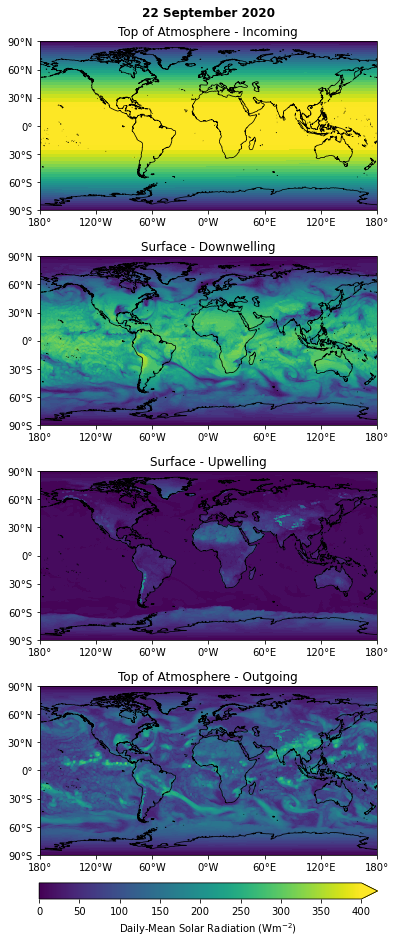

In [7]:
fig, axs = plt.subplots(4, 1, figsize=(11,14), 
                        subplot_kw=dict(projection=ccrs.PlateCarree()))
cmap = cm.viridis
ax1 = axs[0]
ax2 = axs[1]
ax3 = axs[2]
ax4 = axs[3]

plot_geodata(ax1, lats, lons, tisr, 40, 400, cmap, "Top of Atmosphere - Incoming")
plot_geodata(ax2, lats, lons, ssrd, 40, 400, cmap, "Surface - Downwelling")
plot_geodata(ax3, lats, lons, ssru, 40, 400, cmap, "Surface - Upwelling")
plot_geodata(ax4, lats, lons, tosr, 40, 400, cmap, "Top of Atmosphere - Outgoing")

fig.tight_layout(pad=2.0)
fig.suptitle("22 September 2020",
             y=0.999, fontweight="bold")
cbar = fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(vmin=0, vmax=400), 
                                      cmap=cmap), 
                    ax=axs, orientation='horizontal', fraction=.1, shrink=0.45,
                    pad=0.03, extend="max")
cbar.ax.xaxis.set_ticks(np.arange(0, 401, 50), minor=True)
cbar.set_label("Daily-Mean Solar Radiation ($\mathrm{W m^{-2}}$)")
plt.savefig(os.path.join(data_dir, "RER1_Fig1.png"), 
            dpi=300, bbox_inches="tight", facecolor="white")

### Figure 2: Intrinsic Atmospheric Radiative Properties

1. Reflectivity
2. Absorptivity
3. Transmissivity

In [8]:
rom_analysis = xr.open_dataset(os.path.join(data_dir, "rom_analysis.nc"))

lons = rom_analysis.longitude.data
lats = rom_analysis.latitude.data
reflectivity = rom_analysis.r.data
transmissivity = rom_analysis.t.data
absorptivity = rom_analysis.a.data

In [9]:
{"transmittance (min, max)": [transmissivity.min(), transmissivity.max()],
 "absorptance (min, max)": [absorptivity.min(), absorptivity.max()],
 "reflectance (min, max)": [reflectivity.min(), reflectivity.max()]}

{'transmittance (min, max)': [0.27663514, 0.81250435],
 'absorptance (min, max)': [0.12836988, 0.31031913],
 'reflectance (min, max)': [0.04126661, 0.47857818]}

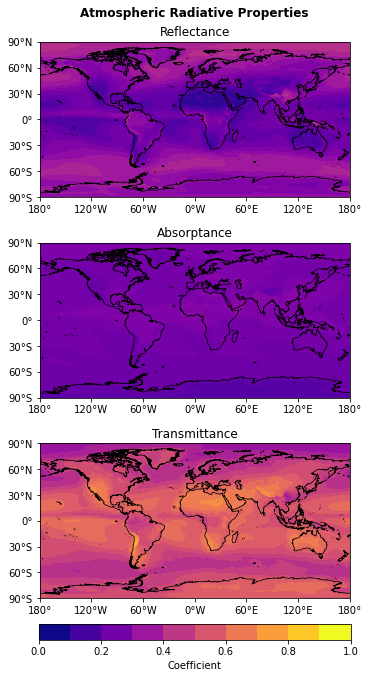

In [10]:
fig, axs = plt.subplots(3, 1, figsize=(11,10), 
                        subplot_kw=dict(projection=ccrs.PlateCarree()))
cmap = cm.plasma
ax1 = axs[0]
ax2 = axs[1]
ax3 = axs[2]

plot_geodata(ax1, lats, lons, reflectivity, 10, 1, cmap, "Reflectance")
plot_geodata(ax2, lats, lons, absorptivity, 10, 1, cmap, "Absorptance")
plot_geodata(ax3, lats, lons, transmissivity, 10, 1, cmap, "Transmittance")

fig.tight_layout(pad=2.0)
fig.suptitle("Atmospheric Radiative Properties",
             y=0.999, fontweight="bold")
cbar = fig.colorbar(cm.ScalarMappable(norm=colors.BoundaryNorm(boundaries=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
                                                               ncolors=cmap.N), 
                                      cmap=cmap), 
                    ax=axs, orientation='horizontal', fraction=.1, shrink=0.415,
                    pad=0.04)
cbar.ax.xaxis.set_ticks(np.arange(0, 1, 20), minor=True)
cbar.set_label("Coefficient")
plt.savefig(os.path.join(data_dir, "RER1_Fig2.png"), 
            dpi=300, bbox_inches="tight",
            facecolor='white')

### Figure 3: Reflectivity Optimization Map

1. Potential surface-reflected outgoing solar radiation
2. Actual surface-reflected outgoing solar radiation
3. Difference (gain)

In [11]:
lons = rom_analysis.longitude.data
lats = rom_analysis.latitude.data
psrosr = rom_analysis.psrosr.data
srosr = rom_analysis.srosr.data
diff = (rom_analysis.psrosr.data - rom_analysis.srosr.data)

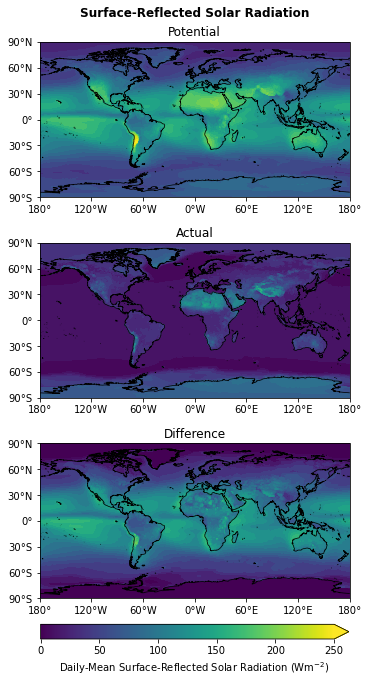

In [12]:
fig, axs = plt.subplots(3, 1, figsize=(11,10), 
                        subplot_kw=dict(projection=ccrs.PlateCarree()))
cmap = cm.viridis
ax1 = axs[0]
ax2 = axs[1]
ax3 = axs[2]

plot_geodata(ax1, lats, lons, psrosr, 25, 250, cmap, "Potential")
plot_geodata(ax2, lats, lons, srosr, 25, 250, cmap, "Actual")
plot_geodata(ax3, lats, lons, diff, 25, 250, cmap, "Difference")

fig.tight_layout(pad=2.0)
fig.suptitle("Surface-Reflected Solar Radiation",
             y=0.999, fontweight="bold")
cbar = fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(vmin=0, vmax=250), 
                                      cmap=cmap), 
                    ax=axs, orientation='horizontal', fraction=.1, shrink=0.41,
                    pad=0.04, extend="max")
cbar.ax.xaxis.set_ticks(np.arange(0, 250, 50), minor=True)
cbar.set_label("Daily-Mean Surface-Reflected Solar Radiation ($\mathrm{W m^{-2}}$)")
plt.savefig(os.path.join(data_dir, "RER1_Fig3.png"), 
            dpi=300, bbox_inches="tight",
            facecolor='white')

## Discussion

In this notebook we developed some publication-quality figures for a Reflective Earth report. This concludes our analysis for now. Additional material can be contributed to existing notebooks or new notebooks via a pull request.

The results of our analysis suggest geographic regions that have the greatest potential to reduce Earth's energy imbalance with surface reflectivity increaes. They are primarily in the tropics and subtropics. Some notable areas include the Andes, Southern Africa, coastal West Africa, Southwest North America, and Australia.

One limitation of our analysis is that we restricted our focus to the annual-mean energy budget. A practical reason to increase reflectivity near human habitations is to reduce heat and hence increase thermal comfort. From this perspective, reflectivity increases may help offset summertime heat. An analysis across the annual cycle could help identify areas with seasonal reflectivity potential.